In [1]:
!nvidia-smi

Sun Nov 17 23:45:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                Off | 00000000:23:00.0 Off |                  Off |
| 33%   33C    P8              11W / 260W |  16586MiB / 49152MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#%pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
#%pip install cucim-cu12 cupy-cuda12x

In [3]:
%pip install fastparquet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%load_ext cudf.pandas

# To desable GPU usage
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
#import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import gc

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # memory limit 16GB (16 * 1024 MB = 16384 MB) 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=16384)] 
        )
        print("Set GPU memory limit to 16GB.")
    except RuntimeError as e:
        print("Error setting memory limit:", e)
else:
    print("No GPUs available.")

#print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


2024-11-17 23:45:23.534166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 23:45:23.564654: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 23:45:23.574037: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 23:45:23.597140: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Set GPU memory limit to 16GB.
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


In [5]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [6]:
num_classes = 11
def filter_invalid_labels(image, label):
    # Exclude labels that are less than 0 or greater than the maximum allowed class
    valid_labels = tf.reduce_all(label >= 0) & tf.reduce_all(label < num_classes)
    return valid_labels

In [7]:
base_path = '/home/workspace/geometry-classifier/data/'

def parse_tfrecord(example_proto):
    """Parse a single TFRecord example."""
    feature_description = {
        'name': tf.io.FixedLenFeature([], tf.string),
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    name = tf.io.decode_raw(parsed_example['name'], tf.float32)
    image = tf.io.decode_raw(parsed_example['image'], tf.float32)
    image = tf.reshape(image, (224, 224, 1))  # Reshape image data to 224x224x3
    class_label = tf.cast(name[0], tf.int32)  # Use the first byte as a class label
    return image, class_label

def load_tfrecord(tfrecord_files):
    """Load TFRecords and prepare a dataset."""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type="GZIP")
    parsed_dataset = raw_dataset.map(parse_tfrecord)
    return parsed_dataset

# Directory with TFRecords

files_for = lambda file_type: glob.glob(f"{base_path}/tfrecord/{file_type}*.tfrecord.gz")

test_files = files_for("test")
validation_files = files_for("val")
train_files = files_for("train")

print(glob.glob(f"{base_path}tfrecord/*.tfrecord.gz")[0])

test = load_tfrecord(test_files).filter(filter_invalid_labels)
test = test.batch(32).prefetch(tf.data.AUTOTUNE)

train = load_tfrecord(train_files).filter(filter_invalid_labels)
train = train.batch(32).prefetch(tf.data.AUTOTUNE)



/home/workspace/geometry-classifier/data/tfrecord/train462.tfrecord.gz


2024-11-17 23:45:27.402323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16384 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:23:00.0, compute capability: 7.5


In [8]:
model = tf.keras.models.load_model(base_path+"model.keras")

In [9]:
from sklearn.metrics import confusion_matrix

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)


I0000 00:00:1731887128.479209  956338 service.cc:146] XLA service 0x7f84c0045980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731887128.479287  956338 service.cc:154]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-11-17 23:45:28.490046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-17 23:45:28.560064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


I0000 00:00:1731887129.266926  956338 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

2024-11-17 23:53:26.064702: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


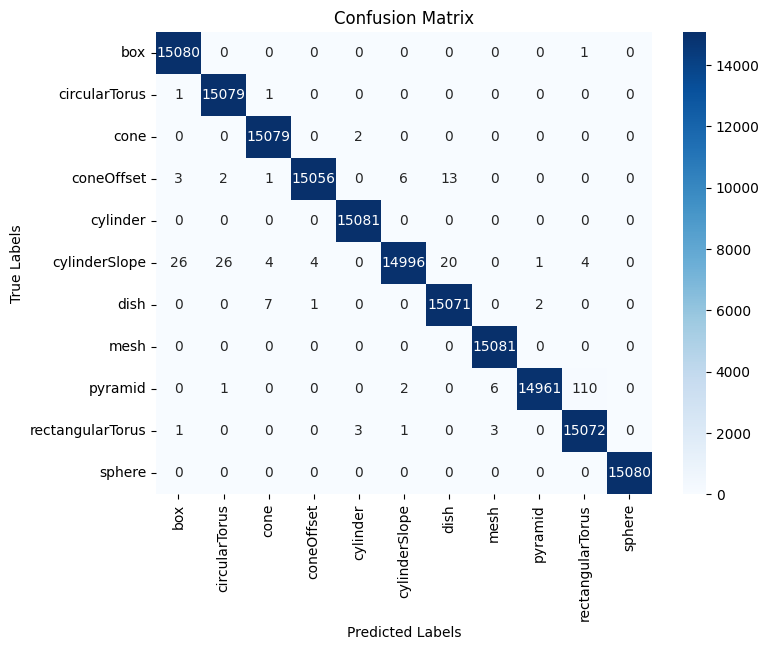

In [11]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=name_mapping, yticklabels=name_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
